In [2]:
# Set working directory to be project path
import os
os.chdir('/home/hice1/avizcaino3/scratch/repos/CS-7643-EfficiencyLane')

In [3]:
# Initialize the model and Loader
from transformers import RobertaConfig, TextClassificationPipeline, RobertaForSequenceClassification
from data_loaders.citation_intent_data_loader import CSTasksDataLoader
from adapters import AutoAdapterModel, RobertaAdapterModel
import torch

model_variant = "roberta-base"

# dataset_name = "sciie"
# adapter_path = "adapters/training_output/roberta-base_sciie_double_seq_bn_training_adapter_v01_best/trial_2/seed_9091"

dataset_name = "citation_intent"
adapter_path = "adapters/training_output/roberta-base_citation_intent_seq_bn_training_adapter_v01_best/trial_2/seed_9091"

print("Loading Dataset...")
loader = CSTasksDataLoader(model_name="roberta-base",
                                dataset_name=dataset_name,
                                path=f"data/{dataset_name}/",
                                checkpoint_path=f"data/{dataset_name}/processed_dataset.pt")

dataset = loader.load_dataset(overwrite=False)
num_labels = loader.num_labels
print("num_labels:", num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ======================================================
# Model & Adapter Config
# ======================================================
# Set up training for the Model and Adapter
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=num_labels,
)

print("Initialising Model...")
model = RobertaAdapterModel.from_pretrained(model_variant, config=config)
model.to(device)

print("Adding Adapter...")
adapter_name = model.load_adapter(adapter_path)
model.set_active_adapters(adapter_name)


/home/hice1/avizcaino3/scratch/.cache/poetry/virtualenvs/cs-7643-efficiencylane-mvGhKmLY-py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hice1/avizcaino3/scratch/.cache/poetry/virtualenvs/cs-7643-efficiencylane-mvGhKmLY-py3.8/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hice1/avizcaino3/scratch/.cache/poetry/virtualenvs/cs-7643-efficiencylane-mvGhKmLY-py3.8/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hice1/aviz

Loading Dataset...
Dataset loaded from checkpoint.
num_labels: 6
Initialising Model...


Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Adding Adapter...


In [4]:
loader.label_encoder

{'Background': 0,
 'Extends': 1,
 'Motivation': 2,
 'CompareOrContrast': 3,
 'Uses': 4,
 'Future': 5}

In [9]:
# Function to predict labels for a list of texts
def classify_texts(model, tokenizer, texts):
    # Prepare the model input
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    input_ids = encoded_inputs['input_ids'].to(model.device)
    attention_mask = encoded_inputs['attention_mask'].to(model.device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        # print(outputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    # Convert predictions to labels (if needed, map these indices back to label names)
    return predictions.cpu().numpy()

In [6]:
import torch

# Get all unique labels in the dataset
unique_labels = torch.unique(torch.tensor(dataset['test']['labels']))
text_by_label = {}

# Extract corresponding texts
for label in unique_labels:
    inx_label = [idx for idx, val in enumerate(dataset['test']['labels']) if val == label.item()]
    text_by_label[label.item()] = [dataset['test']['text'][i] for i in inx_label]

print(text_by_label)


{0: ['But their importance has grown far beyond machine translation : for instance , transferring annotations between languages ( Yarowsky and Ngai 2001 ; Hwa et al. 2005 ; Ganchev , Gillenwater , and Taskar 2009 ) ; discovery of paraphrases ( Bannard and Callison-Burch 2005 ) ; and joint unsupervised POS and parser induction across languages ( Snyder and Barzilay 2008 ) .', 'We experiment with four learners commonly employed in language learning : Decision List ( DL ) : We use the DL learner as described in Collins and Singer ( 1999 ) , motivated by its success in the related tasks of word sense disambiguation ( Yarowsky , 1995 ) and NE classification ( Collins and Singer , 1999 ) .', 'The implementation has been inspired by experience in extracting information from very large corpora ( Curran and Moens , 2002 ) and performing experiments on maximum entropy sequence tagging ( Curran and Clark , 2003 ; Clark et al. , 2003 ) .', 'These keywords are potentially useful features because so

/tmp/ipykernel_217156/3137747428.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_labels = torch.unique(torch.tensor(dataset['test']['labels']))


In [10]:
predictions_by_label = {}

# Load the tokenizer from the data loader
tokenizer = loader.tokenizer

# Classify texts and store predictions
for label, texts in text_by_label.items():
    if texts:
        predictions = classify_texts(model, tokenizer, texts)
        predictions_by_label[label] = predictions
    else:
        predictions_by_label[label] = []

# Print predictions for each label
for label, predictions in predictions_by_label.items():
    print(f"Label {label} Predictions:", predictions)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

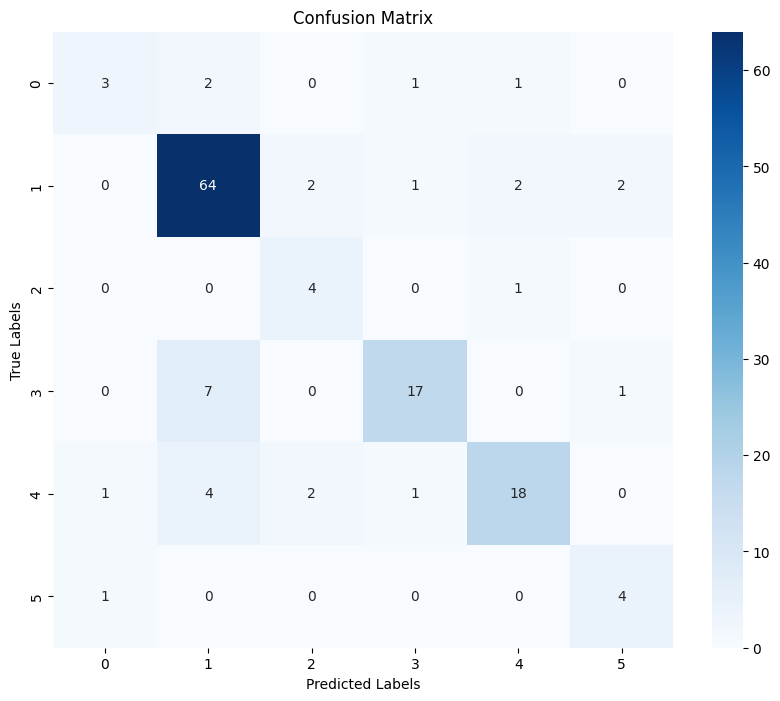

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Aggregate true labels and their predictions
true_labels = []
predicted_labels = []

for true_label, preds in predictions_by_label.items():
    true_labels.extend([true_label] * len(preds))
    predicted_labels.extend(preds)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [5]:
import numpy as np
from transformers import TrainingArguments, EvalPrediction
from adapters import AdapterTrainer
from sklearn.metrics import f1_score

training_args = TrainingArguments(
    learning_rate=0.0009529536457150203,
    num_train_epochs=9,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=9,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def macro_f1(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"macro_f1": f1_score(p.label_ids, preds, average='macro')}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["dev"],
    compute_metrics=macro_f1,
)

/home/hice1/avizcaino3/scratch/.cache/poetry/virtualenvs/cs-7643-efficiencylane-mvGhKmLY-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [6]:
trainer.evaluate()

{'eval_loss': 1.5806162357330322,
 'eval_macro_f1': 0.7430930528239664,
 'eval_runtime': 0.5202,
 'eval_samples_per_second': 219.157,
 'eval_steps_per_second': 24.992}

In [7]:
trainer.evaluate(dataset["test"])

{'eval_loss': 1.5277773141860962,
 'eval_macro_f1': 0.6569663141091713,
 'eval_runtime': 0.3963,
 'eval_samples_per_second': 350.708,
 'eval_steps_per_second': 40.369}